In [1]:
import os
import sys
from typing import Union
from pathlib import Path

import numpy as np
from shapely import (
    Point,
    MultiPoint,
    LineString,
    MultiLineString,
    Polygon,
    LinearRing
)

from shapely.ops import (
    linemerge,
    nearest_points,
    split,
)
import pandas as pd
from pandas import Timestamp
import geopandas as gpd
from geopandas import GeoDataFrame

import matplotlib.pyplot as plt

# Step-by-step

### 1. Manual change of line -> snap line to points

### 2. interpolate line by distance -> 2 points shapefile

### 3. compute the heads for each point -> 1 point shapefile per date (columns = date, head, geometry)

#### Points -> Hc, Hb, Ha -> downstreamwards

$$ \frac{H_c - H_b}{H_c - (H_c - h)} = \frac{d_{cb}}{d} $$



In [2]:
def remove_z_coordinate(in_shp, out_shp, save_file=True):
    """ function to remove the z coordinate from points
    return 3 main points
    """
    in_gdf = gpd.read_file(in_shp)
    out_gdf = in_gdf.copy()
    
    new_geometry = [
        Point(
            list(point.coords)[0][:2]
        )
        for point in in_gdf.geometry
    ]
    out_gdf['geometry'] = new_geometry            # all of the points are here, without Z

    out_gdf_dropped = out_gdf.drop_duplicates(
        subset='geometry'
    ).drop_duplicates(
        subset='StationNam'
    ).reset_index(
        drop=True
    )
    if save_file: out_gdf_dropped.to_file(out_shp)
        
    return out_gdf_dropped

In [3]:
def split_line (in_line: LineString,
                in_points: MultiPoint):
    
    pts = [point for point in in_points.geoms]

    pts = [
        in_line.interpolate(in_line.project(pt))
        for pt in pts
    ]
    
    out_pts = MultiPoint(pts)
    out_line = split(in_line, out_pts)
    
    
    return out_line, out_pts

In [4]:
# Naming convention in Pep8

def interpolate_by_distance (in_line: LineString,
                             split_distance: Union[int, float]
                             ) -> MultiPoint:
    """Function to get populate a shapely Linestring with points.

    Args:
        in_line (LineString): geometry one wishes to split.
        split_distance (Union[int, float]): distance between points.

    Returns:
        Points over the line (MultiPoint)
    """

    line = in_line
    space = split_distance
    n_points = int(line.length / space)     # that will split the lines
    points_list = [
        line.interpolate((i/n_points), normalized=True)
        for i in range(1, n_points)
        ]
    # append extreme points
    
    points_list.append(Point(list(line.coords)[0]))
    points_list.append(Point(list(line.coords)[-1]))

    points = MultiPoint(points_list)
    return points


In [5]:
def points_from_line(in_shp, out_shp, split_distance, save_file=True):
    """converts reference_line_river with unjoined lines into points"""

    reference_line = gpd.read_file(ref_path)
    crs = reference_line.crs
    line = reference_line.unary_union
    # multipoints
    mps = interpolate_by_distance(
        in_line=line,
        split_distance=split_distance
    )

    out_gdf = gpd.GeoDataFrame(
        geometry=[mps],
        crs=crs
    ).explode(
        index_parts=True
    ).reset_index(
        drop=True
    )

    if save_file: out_gdf.to_file(out_shp)
        
    return out_gdf


In [31]:
def compute_heads(date: Timestamp,
                  h1: float,
                  h0: float,
                  interpolated_points: GeoDataFrame) -> GeoDataFrame:

    interpolated_points['y'] = interpolated_points.geometry.y
    sorted_interpolated_points = interpolated_points.sort_values(
        by='y', ascending=False
    ).reset_index(drop=1)

    out_gdf = sorted_interpolated_points.copy()
    _ = np.zeros_like(out_gdf.index)
    # interpolate
    heads = np.linspace(h1, h0, len(_)) # north comes before
    out_gdf ['head'] = heads    
    out_gdf['date'] = date
    out_gdf = out_gdf[['date', 'head', 'geometry']]
    
    return out_gdf

def prepare_table(csv_path):
    csv_path = raw.joinpath(csv_path)
    df = pd.read_csv(csv_path)
    df['Date'] = pd.to_datetime(df.Date)
    sorted_df =  df.sort_values(
        by=['UTM33U_HW'],
        ascending=False
    ).reset_index(
        drop=True
    )

    cols_north_order = ['Date'] + list(sorted_df.Name_Station.unique())

       
    
    pivot_df = pd.pivot_table(
        sorted_df, values='River_WL', columns='Name_Station', index=['Date']
    ).rename_axis(
        columns=''
    ).reset_index()

    pivot_north_order_df = pivot_df[cols_north_order]

    return pivot_north_order_df 

def heads_from_table(pivot_table, stations_group, interpolated_points):
    stations = pivot_table.columns[1:]
    drop_stations = [
        station for station in stations
        if station not in stations_group
                    ]
    pivot_slice = pivot_table.drop(drop_stations, axis=1)

    #order = date, h1, h0
    heads_df = pivot_slice.apply(
        lambda row:
        compute_heads(*row, interpolated_points=interpolated_points),
        axis=1
    )
    
    
    return heads_df

def contatenate_parts(df1, df2):
    return pd.concat([df1, df2]).reset_index(drop=True)

vectorized_concat = np.vectorize(contatenate_parts)

def export_results(df1, df2, drop_date_column=False, save=False, base_path=None):
    heads_arr = vectorized_concat(df1, df2)
    
    for df in heads_arr:
        fn = str(df.date.unique()[0].date()) + '_heads.shp'
        save_path = base_path.joinpath(fn)
        if drop_date_column:
            out_df = df.drop('date', axis=1)
            if save:
                out_df.to_file(save_path)
        else:
            df['date'] = df.date.astype('str')
            if save:
                df.to_file(save_path)
        
    return heads_arr

In [7]:
def plot_results(heads_arr):
    for df in heads_arr:
        df.plot(column='head', legend=True)
        date = str(df.date.unique()[0].date())
        plt.title(f'Heads for {date}')
        plt.show()

In [10]:
def add_name_version(in_path: Path, sufix):
    """adding sufix to names. There can't be any points in the path"""
    out_path = f"{str(in_path).split('.')[0]}{sufix}.{str(in_path).split('.')[-1]}"
    return Path(out_path)

### Run

In [33]:
# define directorties

root_dir = Path(os.getcwd()).parents[0]
raw = root_dir.joinpath('data/raw')
edit = root_dir.joinpath('data/edit')
output = root_dir.joinpath('data/output')

In [13]:
# step 1
sts_name = raw.joinpath('Neisse_WL_2017.shp')
sts_edit_name = edit.joinpath('edit_Neisse_WL_2017.shp')
stations = remove_z_coordinate(
    in_shp=sts_name,
    out_shp=sts_edit_name
)

In [14]:
# step 2 - split river line at each station

in_path = edit.joinpath('reference_line_river.shp')
in_gdf = gpd.read_file(in_path)
in_line = in_gdf.unary_union
mps = stations.unary_union
split_river, new_stations = split_line(in_line, mps)

for i, geo in enumerate(split_river.geoms):
    gdf = gpd.GeoDataFrame(geometry=[geo], crs=in_gdf.crs)
    out_path = add_name_version(in_path, sufix=f'_{i}')
    gdf.to_file(out_path)

In [15]:
# reorder snapped stations and save them
snapped_geos = list(new_stations.geoms)
replace_geos = []
for i, geo in enumerate(stations.geometry):
    new_geo = [new_geo_i for new_geo_i in snapped_geos if new_geo_i.distance(geo) < 100][0]
    replace_geos.append(new_geo)
    
stations['geometry'] = replace_geos
out_path = add_name_version(sts_edit_name, sufix=f'_v{2}') 
stations.to_file(out_path)

In [16]:
# step 3
# get points from each splitted line
splitted_lines = [
    line for line in os.listdir(edit)
    if line.startswith('reference_line_river_')
    if line.endswith('shp')
]
ref_out_path = edit.joinpath('interpolated_points_river.shp')
interpolated_points = []
for i, line_shp in enumerate(splitted_lines):
    split_distance = 5
    ref_path = edit.joinpath(line_shp)
    out_path = add_name_version(ref_out_path, sufix=f'_{i}')
    interp_points = points_from_line(
        ref_path,
        out_path,
        split_distance
    )
    interpolated_points.append(interp_points)

In [17]:
csv_path = raw.joinpath('River_WL_2017.csv')
pivot_df = prepare_table(csv_path)        # columns index are organizing from north to south

pair1 = ['Neisse_Hagenwerder', 'Neisse_NPS' ]
pair2 = ['Neisse_NPS', 'Neisse_Goerlitz']

pair1_gdf = stations.loc[
    stations.StationNam.isin(pair1)
]
pair2_gdf = stations.loc[
    stations.StationNam.isin(pair2)
]

interp_points2 = interpolated_points[0]
interp_points1 = interpolated_points[1]

In [34]:
results_pair1 = heads_from_table(pivot_df, pair1, interp_points1)
results_pair2 = heads_from_table(pivot_df, pair2, interp_points2)


save = True

heads_arr = export_results(
    results_pair1,
    results_pair2,
    drop_date_column=False,
    save=save,
    base_path=output
)

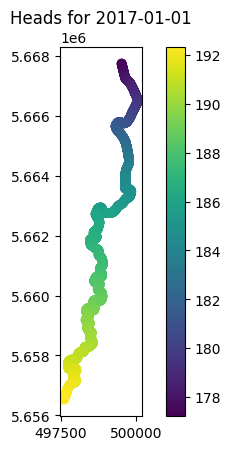

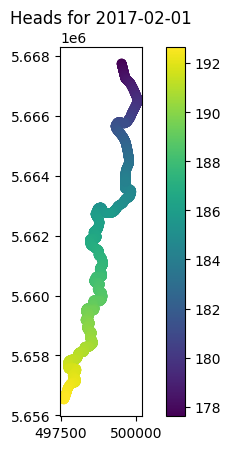

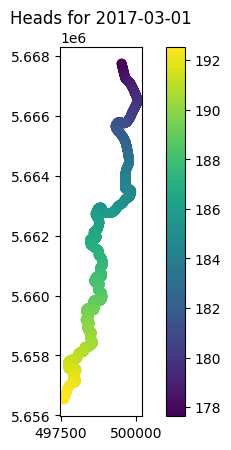

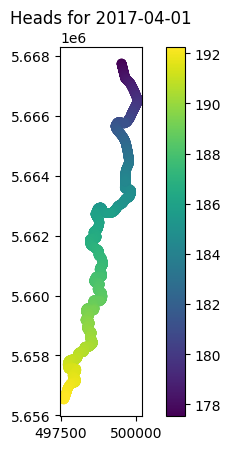

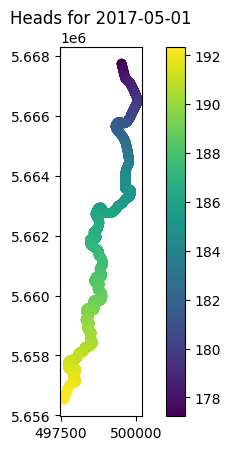

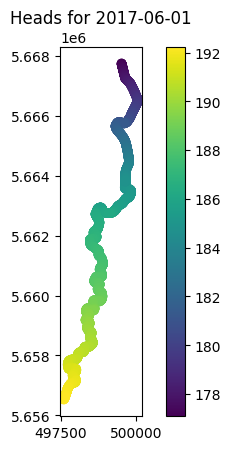

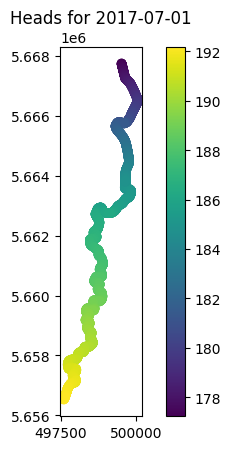

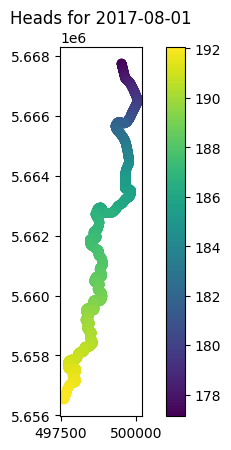

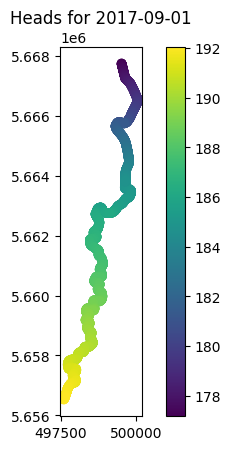

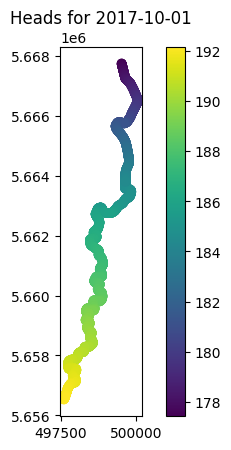

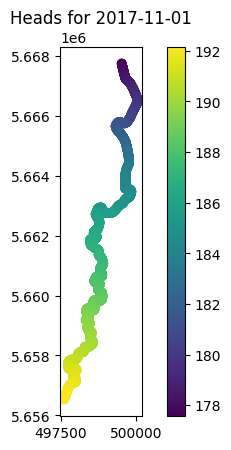

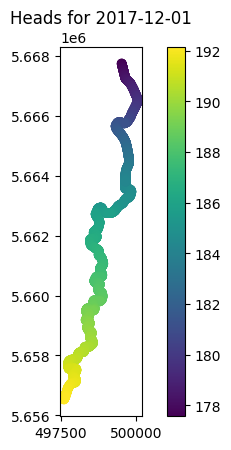

In [19]:
plot_results(heads_arr)

## References

https://peps.python.org/pep-0008/